In [1]:
!git clone https://github.com/facebookresearch/FixRes

Cloning into 'FixRes'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 126 (delta 25), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (126/126), 1.42 MiB | 1.57 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [0]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [0]:
from FixRes.transforms_v2 import get_transforms  # Implement FixRes method for fine-tuning

In [4]:
torch.__version__

'1.5.0+cu101'

In [0]:
root_model = 'drive/My Drive/Colab Notebooks/P7/model/'

In [0]:
dir_train = 'drive/My Drive/Colab Notebooks/P7/data/train'

In [0]:
dir_valid = 'drive/My Drive/Colab Notebooks/P7/data/valid'

In [0]:
dir_test = 'drive/My Drive/Colab Notebooks/P7/data/test'

#FixRes method for image preprocessing


In [0]:
fixRes_image_transforms = get_transforms(input_size=320,test_size=224, kind='full', crop=True, need=('train', 'val'), backbone=None)

#Data Loader

```
Data loader Stanford Dog
```

In [0]:
batch_size = 32

In [0]:
data_images = {
    'train': datasets.ImageFolder(root=dir_train, transform=fixRes_image_transforms['train']),
    'valid': datasets.ImageFolder(root=dir_valid, transform=fixRes_image_transforms['val_test']),
    'test': datasets.ImageFolder(root=dir_test, transform=fixRes_image_transforms['val_test'])
}

In [0]:
dataloaders = {
    'train': DataLoader(data_images['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data_images['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data_images['test'], batch_size=batch_size, shuffle=True)
}

In [0]:
dataset_sizes = {x: len(data_images[x]) for x in ['train', 'valid', 'test']}

In [14]:
dataset_sizes

{'test': 4140, 'train': 12240, 'valid': 4200}

In [0]:
class_names = data_images['train'].classes

In [16]:
class_names[:3]

['Afghan_hound', 'African_hunting_dog', 'Airedale']

#ResNext as fixed feature extractor

In [17]:
# Load resnext model
fixRes_model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x48d_wsl')

Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x48-3e41cc8a.pth


In [0]:
# Freeze model weights
for param in fixRes_model.parameters():
    param.requires_grad = False

In [0]:
num_ftrs = fixRes_model.fc.in_features

In [0]:
fixRes_model.fc = nn.Linear(num_ftrs, 120)

In [21]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in fixRes_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in fixRes_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

826,608,056 total parameters.
245,880 training parameters.


```
Move to gpu if available
```

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fixRes_model = fixRes_model.to(device)

In [23]:
device

device(type='cuda', index=0)

```
Training Loss and Optimizer
```

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.Adam(fixRes_model.parameters())

#Training

In [0]:
def train_model(model, criterion, optimizer, num_epochs=30):

    since = time.time()

    global history
    history = {'train':{'val_accuracy':[], 'val_loss':[]}, 'valid':{'val_accuracy':[], 'val_loss':[]}}

    # Weights model
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())

    # Early stopping details
    n_epochs_stop = 5
    min_val_loss = np.Inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i = 0
            print('{} :'.format(phase), end=" ")
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # display evolving
                if(not i % 50):
                    print("{}%".format((i*100//(dataset_sizes[phase]//batch_size))), end=" => ")
                i += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[phase]['val_loss'].append(epoch_loss)
            history[phase]['val_accuracy'].append(epoch_acc)
            print("100%")
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                if epoch_loss < min_val_loss:
                    epochs_no_improve = 0
                    min_val_loss = epoch_loss
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == n_epochs_stop:
                        time_elapsed = time.time() - since
                        print()
                        print('Early stopping!')
                        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                        print('Best val Acc: {:4f}'.format(best_acc))
                        model.load_state_dict(best_model)
                        return model
                print("Valeur de perte minimale : {:.4f}".format(min_val_loss), end="; ")
                print("Nombre epochs non amélioré : {}".format(epochs_no_improve))
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model)
    return model

In [27]:
fixRes_model = train_model(fixRes_model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
train : 0% => 13% => 26% => 39% => 52% => 65% => 78% => 91% => 100%
train Loss: 1.3776 Acc: 0.7016
valid : 0% => 38% => 76% => 100%
valid Loss: 0.3538 Acc: 0.9190
Valeur de perte minimale : 0.3538; Nombre epochs non amélioré : 0

Epoch 2/30
----------
train : 0% => 13% => 26% => 39% => 52% => 65% => 78% => 91% => 100%
train Loss: 0.8354 Acc: 0.7993
valid : 0% => 38% => 76% => 100%
valid Loss: 0.3248 Acc: 0.9271
Valeur de perte minimale : 0.3248; Nombre epochs non amélioré : 0

Epoch 3/30
----------
train : 0% => 13% => 26% => 39% => 52% => 65% => 78% => 91% => 100%
train Loss: 0.8409 Acc: 0.8105
valid : 0% => 38% => 76% => 100%
valid Loss: 0.3177 Acc: 0.9407
Valeur de perte minimale : 0.3177; Nombre epochs non amélioré : 0

Epoch 4/30
----------
train : 0% => 13% => 26% => 39% => 52% => 65% => 78% => 91% => 100%
train Loss: 0.8790 Acc: 0.8068
valid : 0% => 38% => 76% => 100%
valid Loss: 0.3381 Acc: 0.9336
Valeur de perte minimale : 0.3177; Nombre epochs non amélio

In [0]:
torch.save(fixRes_model.state_dict(), root_model + "model")

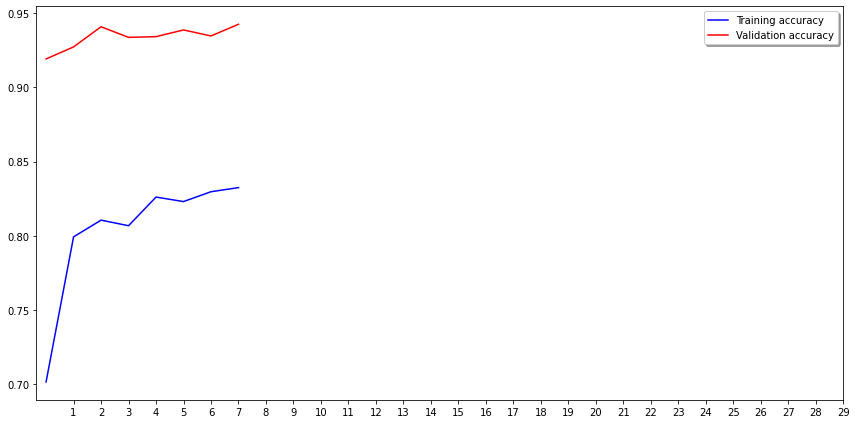

In [34]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(history['train']['val_accuracy'], color='b', label="Training accuracy")
ax.plot(history['valid']['val_accuracy'], color='r',label="Validation accuracy")
ax.set_xticks(np.arange(1, 30, 1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

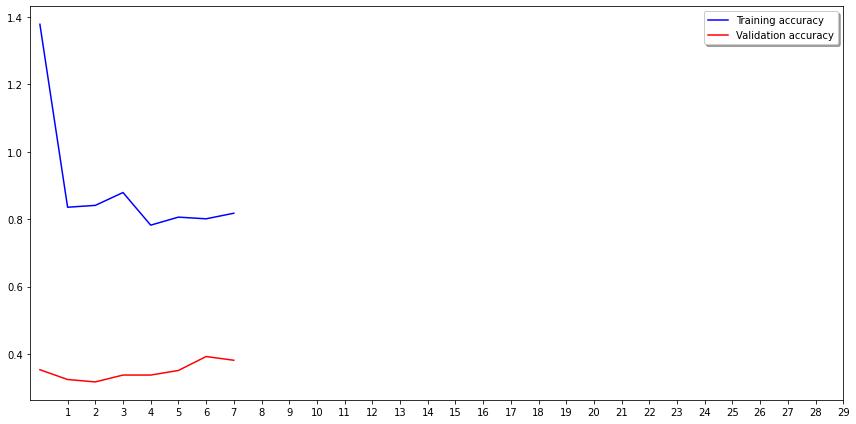

In [35]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(history['train']['val_loss'], color='b', label="Training accuracy")
ax.plot(history['valid']['val_loss'], color='r',label="Validation accuracy")
ax.set_xticks(np.arange(1, 30, 1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#Evaluation


In [0]:
def evaluation(fixRes_model):
    equals = 0
    i = 0
    corrects = 0
    with torch.no_grad():
        for data, targets in dataloaders['test']:
            data = data.to(device)
            targets = targets.to(device)

            outputs = fixRes_model(data)

            outputs = torch.nn.functional.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            corrects += torch.sum(preds == targets)

            if(not i % 20):
                print("{}%".format((i*100//(dataset_sizes["test"]//batch_size))), end=" => ")
            i += 1
        print("100%")
        print("Accuracy is : {}".format(corrects.item()/dataset_sizes['test']))

In [30]:
evaluation(fixRes_model)

0% => 15% => 31% => 46% => 62% => 77% => 93% => 100%
Accuracy is : 0.9473429951690822


#Visualizing the model predictions

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

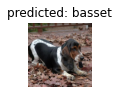

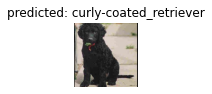

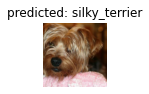

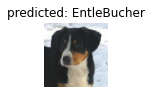

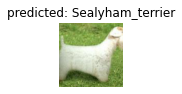

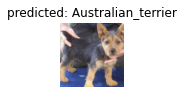

In [33]:
visualize_model(fixRes_model)